## Intro

- `Start :` its the point of starting the application running
- `End    :` its the point of ending the application running
- `State :` its like the memory of our agent , storing the informations of current state
- `Node  :` its simple function or method to do some operations from the state and update it
- `Edge  :` its the connections or path between the nodes 
- `Condetional Edges :` its descion based on specific condition to determine the next node
- `Graph :` its like the entire map of the process , and shows how all nodes connected and how the logic flow
- `StateGraph :` its the builder and manager of the entire stateful workflow , and its organize nodes , connects them with edges , maintains the shared state , and compile everything into runnable graph

## Simple basic graph
- define state 
- understand flow through a single node
- build and compile graph

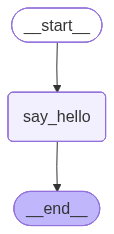

In [1]:
from typing import TypedDict , List# Building the structure of our agent state
from langgraph.graph import StateGraph , START , END # builder and manager of the entire stateful workflow

In [2]:
class AgentState(TypedDict):
    name : str 
    operator : str
    display_name : str
    numbers : List[int]
    Muls : int
    Sums : int 

In [3]:
def hello(state:AgentState) -> AgentState : 
    state["display_name"] = "Hello , nice to meet you " + state["name"]
    return state

def Muls(state:AgentState) -> AgentState :
    Muls = 1
    for num in state["numbers"]:
        Muls = Muls * num
    state["Muls"] = Muls
    return state

def Sums(state:AgentState) -> AgentState :
    Sums = 0
    for num in state["numbers"]:
        Sums = Sums + num
    state["Sums"] = Sums
    return state

def router (state:AgentState) -> AgentState : 
    if state['operator'] == "+" : 
        return "Sums"
    else :
        return "Muls"

In [4]:
graph = StateGraph(AgentState)

graph.add_node("say_hello" , hello)
graph.add_node("Muls" , Muls)
graph.add_node("Sums", Sums)

graph.add_edge(START ,"say_hello")

graph.add_conditional_edges(
    "say_hello", 
    router, 
    {
        "Sums":"Sums", 
        "Muls" : "Muls"
    }
)

graph.add_edge("Muls",END)
graph.add_edge("Sums",END)

agent = graph.compile()

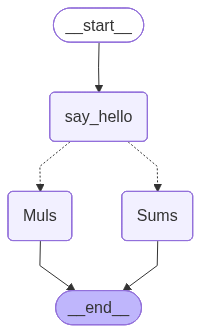

In [5]:
from IPython.display import display , Image

display(Image(agent.get_graph().draw_mermaid_png()))

In [10]:
final_state = agent.invoke({"name":"ali" , "numbers" : [4,7,23,5] , "operator":"+"})
final_state

{'name': 'ali',
 'operator': '+',
 'display_name': 'Hello , nice to meet you ali',
 'numbers': [4, 7, 23, 5],
 'Sums': 39}

In [11]:
final_state = agent.invoke({"name":"ali" , "numbers" : [4,7,23,5] , "operator":"*"})
final_state

{'name': 'ali',
 'operator': '*',
 'display_name': 'Hello , nice to meet you ali',
 'numbers': [4, 7, 23, 5],
 'Muls': 3220}

## Using LLMs

In [70]:
from typing import TypedDict , List
from langgraph.graph import StateGraph , START , END 
from langchain_core.messages import HumanMessage , BaseMessage
from langchain_ollama import ChatOllama

In [71]:
llm = ChatOllama(
    model="qwen3:4b",
    temperature=0
)

In [72]:
class AgentState(TypedDict):
    messages: List[BaseMessage]

In [85]:
def invoke_llm(state: AgentState) -> AgentState:
    response = llm.invoke(state["messages"])
    print("AI : ", response.content)
    state["messages"].append(response)
    return state


In [86]:
graph = StateGraph(AgentState)

graph.add_node("invoke" , invoke_llm)

graph.add_edge(START , "invoke")
graph.add_edge("invoke",END)

llm_graph = graph.compile()

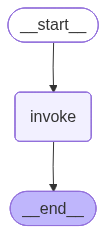

In [87]:
llm_graph

In [88]:
input_state = {
    "messages":[HumanMessage(content="how are you?")]
}

llm_graph.invoke(input_state)

AI :  Hi there! 😊 I'm an AI, so I don't have feelings, but I'm here to help you out. How can I assist you today?


{'messages': [HumanMessage(content='how are you?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="Hi there! 😊 I'm an AI, so I don't have feelings, but I'm here to help you out. How can I assist you today?", additional_kwargs={}, response_metadata={'model': 'qwen3:4b', 'created_at': '2025-11-23T10:27:37.0694264Z', 'done': True, 'done_reason': 'stop', 'total_duration': 10988219700, 'load_duration': 82706200, 'prompt_eval_count': 14, 'prompt_eval_duration': 256750700, 'eval_count': 612, 'eval_duration': 10534522600, 'logprobs': None, 'model_name': 'qwen3:4b', 'model_provider': 'ollama'}, id='lc_run--34a823f3-cfda-4896-9109-71a01ed2491c-0', usage_metadata={'input_tokens': 14, 'output_tokens': 612, 'total_tokens': 626})]}

## Using LLMs + Tools

In [118]:
from typing import TypedDict , List , Annotated , Sequence
from langgraph.graph import StateGraph , START , END 
from langchain_core.messages import HumanMessage , BaseMessage , SystemMessage
from langchain_ollama import ChatOllama
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

In [119]:
llm = ChatOllama(
    model="qwen3:4b",
    temperature=0
)

In [120]:
class AgentState(TypedDict) : 
    messages : Annotated[Sequence[BaseMessage],add_messages]

In [121]:
@tool 
def additoin(a:int , b:int) : 
    """Take 2 numbers and adding it"""
    return a+b

In [123]:
model = llm.bind_tools([additoin])

In [124]:
def invoke_llm(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(content="You are Mathematical assistant , please answer my query.")
    response = model.invoke([system_prompt]+state["messages"])
    print("AI : ", response.content)
    state["messages"].append(response)
    return state

def router(state: AgentState) -> AgentState:
    mes = state['messages'][-1]
    if not mes.tool_calls : 
        return "end"
    else :
        return "continue"

In [125]:
graph = StateGraph(AgentState) 

tool = ToolNode(tools=[additoin])

graph.add_node("llm_call" , invoke_llm)
graph.add_node("tool_call" , tool)

graph.add_edge(START , "llm_call")
graph.add_conditional_edges(
    "llm_call" ,
    router ,
    {
        "end" : END , 
        "continue" : "tool_call"
    }
)
graph.add_edge("tool_call","llm_call")
graph.add_edge("llm_call",END)


g = graph.compile()

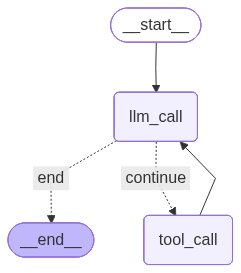

In [126]:
g

In [127]:
input_state = {
    "messages":[HumanMessage(content="what is 2+4?")]
}

res = g.invoke(input_state)

AI :  
AI :  The result of 2 + 4 is 6.


In [128]:
res

{'messages': [HumanMessage(content='what is 2+4?', additional_kwargs={}, response_metadata={}, id='7ece0b46-4acb-4689-9e80-cf2bde5f55eb'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:4b', 'created_at': '2025-11-23T15:03:02.4365493Z', 'done': True, 'done_reason': 'stop', 'total_duration': 4870310700, 'load_duration': 94078300, 'prompt_eval_count': 163, 'prompt_eval_duration': 816822400, 'eval_count': 224, 'eval_duration': 3893589400, 'logprobs': None, 'model_name': 'qwen3:4b', 'model_provider': 'ollama'}, id='lc_run--e6a9fbeb-79c5-4e5c-9081-5d9828b52563-0', tool_calls=[{'name': 'additoin', 'args': {'a': 2, 'b': 4}, 'id': '87e99772-3031-4f79-bbfb-b955369da0ac', 'type': 'tool_call'}], usage_metadata={'input_tokens': 163, 'output_tokens': 224, 'total_tokens': 387}),
  ToolMessage(content='6', name='additoin', id='35d51944-46be-4ee6-bfb6-e2642059505c', tool_call_id='87e99772-3031-4f79-bbfb-b955369da0ac'),
  AIMessage(content='The result of 2 + 4 is 6.', 